In [1]:
import itertools
import math
import os
import re
import urllib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from lxml import html
from matplotlib.colors import LogNorm
from rdkit import Chem

In [2]:
tqdm.tqdm = tqdm.tqdm_notebook

In [3]:
sns.set(style='white', rc={'axes.facecolor': (0, 0, 0, 0),
                            'font.family': 'serif'})
sns.set_context('paper', font_scale=2.5)

In [4]:
def get_num_spectrum_files(task_id, extension=None):
    with urllib.request.urlopen(f'https://proteomics2.ucsd.edu/ProteoSAFe/'
                                f'status.jsp?task={task_id}') as f_url:
        num_files_str = html.fromstring(f_url.read()).xpath(
            '//th[text()="Spectrum Files"]/following-sibling::td/'
            'descendant::*/text()')
        return sum([1 for line in num_files_str
                    if extension is None
                    or line.strip().lower().endswith(extension.lower())])

In [5]:
def inchi_to_smiles(inchi):
    try:
        mol = Chem.rdinchi.InchiToMol(inchi)[0]
    except ValueError:
        mol = None
    return Chem.MolToSmiles(mol, True) if mol is not None else None

In [6]:
def plot_cosine_vs_balance(scores_df, x_labels, y_labels):
    fig, ax = plt.subplots(figsize=(9, 6))
    
    sns.heatmap(scores_df, square=False,
                cbar_kws={'label': 'Correct annotations'},
                xticklabels=x_labels, yticklabels=y_labels,
                cmap=sns.cm.rocket_r, ax=ax)
    
    ax.invert_yaxis()
    
    ax.xaxis.set_tick_params(rotation=0)
    
    ax.xaxis.set_major_locator(mticker.AutoLocator())
    ax.yaxis.set_major_locator(mticker.AutoLocator())

    ax.set_xlabel('Cosine score')
    ax.set_ylabel('Balance score (%)')
    
    return fig, ax

In [7]:
def ridge_plot_scores(scores_df, num_files):
    palette = sns.color_palette('Blues_d', n_colors=len(
        scores_df['filename'].unique()))
    palette.reverse()
    fg = sns.FacetGrid(scores_df, row='filename', hue='filename',
                       col='spiked', height=0.5, aspect=15, palette=palette)

    fg.map(sns.kdeplot, 'score', shade=True, alpha=1., lw=1.5)
    fg.map(sns.kdeplot, 'score', color='white', lw=2.)
    fg.map(plt.axhline, y=0., lw=2.)

    for ax in fg.axes.ravel():
        ax.set_xlim(0.4, 1.)
    fg.set(xticks=np.arange(0.5, 1.05, 0.1))

    fg.axes[-1, 0].set_xlabel('Cosine score')
    fg.axes[-1, 1].set_xlabel('Cosine score')
    fg.axes[len(fg.axes) // 2, 0].set_ylabel('Number of files')
    for ax, label, color in zip([*fg.axes[:, 0], *fg.axes[:, 1]],
                                itertools.cycle(num_files),
                                itertools.cycle(palette)):
        ax.text(0, .2, label, color=color, ha='left', va='center',
                transform=ax.transAxes)

    fg.set_titles('')
    fg.axes[0, 0].set_title('All compounds')
    fg.axes[0, 1].set_title('Spiked-in compounds')
    fg.set(yticks=[])
    fg.despine(bottom=True, left=True)

    fg.fig.subplots_adjust(hspace=-0.35)
    
    return fg

In [8]:
data_dir = '../data/Biswa'
metadata = (pd.read_csv(os.path.join(data_dir, 'metadata.csv'))
            .dropna(subset=['GNPS deconvolution link',
                            'GNPS library search link']))

In [9]:
compounds_spiked = pd.read_csv(os.path.join(data_dir,
                                            'compounds_spiked.csv'))
smiles_spiked = set(compounds_spiked['SMILES'])

In [10]:
# Get the identifications for each task.
filenames_search, compounds = [], []
for library_link in tqdm.tqdm(metadata['GNPS library search link'],
                              'Files loaded', unit='files'):
    task_id = library_link[library_link.rfind('=') + 1:][:8]
    filename = (f'MOLECULAR-LIBRARYSEARCH-GC-{task_id}'
                f'-view_all_annotations_DB-main.tsv')
    filenames_search.append(filename)
    compounds_file = (pd.read_csv(os.path.join(data_dir, filename),
                                  sep='\t',
                                  usecols=['#Scan#', 'INCHI', 'MQScore',
                                           'Balance_score(percentage)'],
                                  skipinitialspace=True)
                      .dropna())
    compounds_file['SMILES'] =\
        compounds_file['INCHI'].apply(inchi_to_smiles)
    compounds_file['matches_spiked_compound'] =\
        compounds_file['SMILES'].isin(smiles_spiked)
    compounds_file = compounds_file.drop('INCHI', 'columns').dropna()
    compounds.append(compounds_file)

# Get the number of files for each task.
num_files = [
    get_num_spectrum_files(
        deconvolution_link[deconvolution_link.rfind('=') + 1:], '.mzml')
    for deconvolution_link in metadata['GNPS deconvolution link']
]

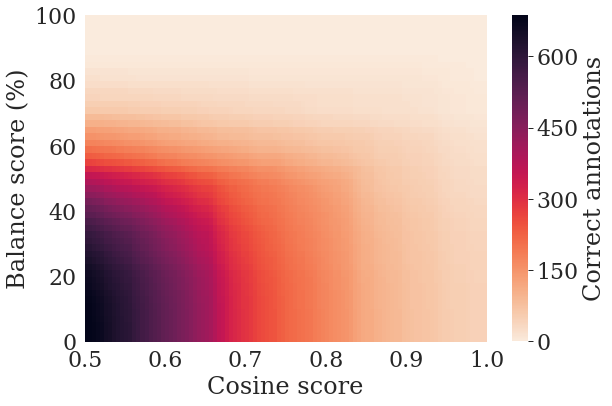

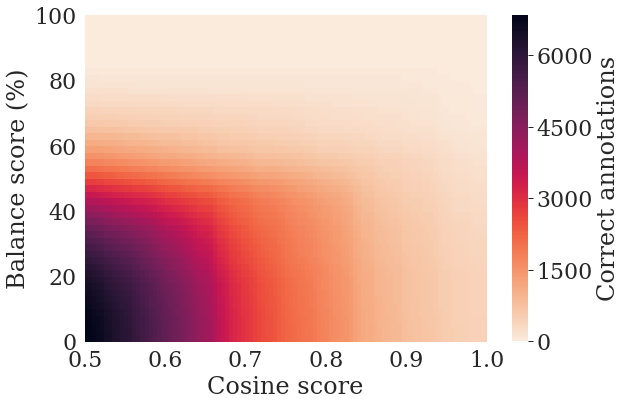

In [11]:
cosine_thresholds = np.arange(0.51, 1.01, 0.01)
balance_thresholds = np.arange(1, 101, 1)

for top in (1, 10):
    compounds_top = (
        compounds[-1].sort_values(['#Scan#', 'MQScore'],
                                   ascending=[True, False])
        .groupby('#Scan#').head(top))
    
    compounds_score_map = np.zeros((len(cosine_thresholds),
                                    len(balance_thresholds)))
    for i, cosine_threshold in enumerate(cosine_thresholds):
        for j, balance_threshold in enumerate(balance_thresholds):
            compounds_score_map[i, j] = len(compounds_top[
                (compounds_top['MQScore'] >= cosine_threshold) &
                (compounds_top['Balance_score(percentage)'] >= balance_threshold)])
    plot_cosine_vs_balance(compounds_score_map,
                           [f'{c:0.1f}' for c in np.arange(0.5, 1.05, 0.1)],
                           np.arange(0, 101, 20))

    plt.savefig(f'cosine_vs_balance_top{top}.png', dpi=300)
    plt.show()
    plt.close()

/home/wout/.conda/envs/dorrestein/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
/home/wout/.conda/envs/dorrestein/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


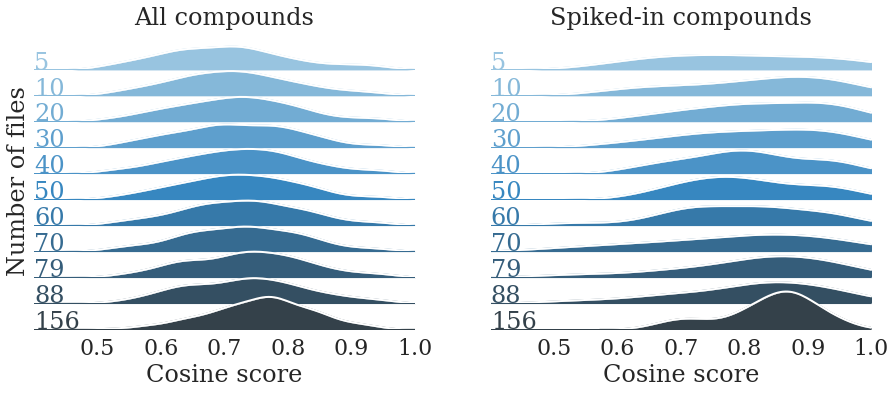

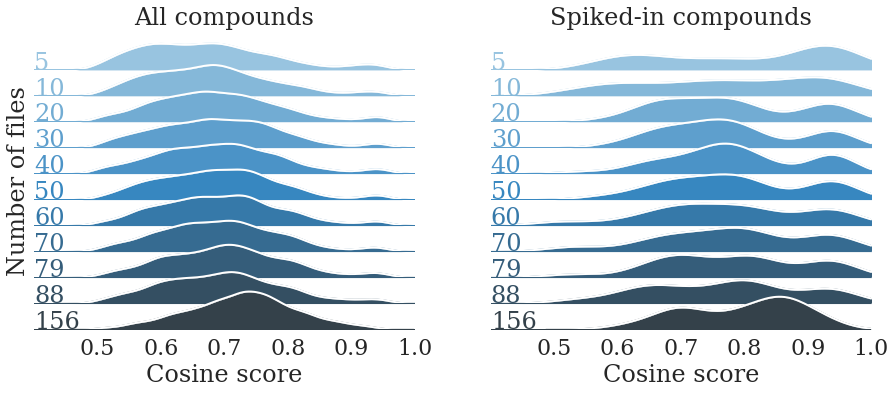

In [12]:
for top in (1, 10):
    num_files_top, scores_top, spiked = [], [], []
    for compounds_file, num in zip(compounds, num_files):
        compounds_top = (
            compounds_file.sort_values(['#Scan#', 'MQScore'],
                                       ascending=[True, False])
            .groupby('#Scan#').head(top))
        num_files_top.extend([num] * len(compounds_top))
        scores_top.extend(compounds_top['MQScore'])
        spiked.extend([False] * len(compounds_top))
        compounds_top_spiked = compounds_top[compounds_top['matches_spiked_compound']]
        num_files_top.extend([num] * len(compounds_top_spiked))
        scores_top.extend(compounds_top_spiked['MQScore'])
        spiked.extend([True] * len(compounds_top_spiked))
    
    ridge_plot_scores(pd.DataFrame(
        data={'filename': num_files_top, 'score': scores_top,
              'spiked': spiked}), [*num_files, *num_files])

    plt.savefig(f'cosine_spiked_top{top}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [13]:
# Final figures for the manuscript.
cosine_thresholds = np.arange(0.51, 1.01, 0.01)
balance_thresholds = np.arange(1, 101, 1)

for top in (1, 10):
    compounds_top = (
        compounds[-1].sort_values(['#Scan#', 'MQScore'],
                                   ascending=[True, False])
        .groupby('#Scan#').head(top))

    compounds_score_map = np.zeros((len(cosine_thresholds),
                                    len(balance_thresholds)))
    for i, cosine_threshold in enumerate(cosine_thresholds):
        for j, balance_threshold in enumerate(balance_thresholds):
            compounds_score_map[i, j] = len(compounds_top[
                (compounds_top['MQScore'] >= cosine_threshold) &
                (compounds_top['Balance_score(percentage)'] >= balance_threshold)])
    plot_cosine_vs_balance(compounds_score_map,
                           [f'{c:0.1f}' for c in np.arange(0.5, 1.05, 0.1)],
                           np.arange(0, 101, 20))

    plt.savefig(f'cosine_vs_balance_top{top}.svg', dpi=300)
    plt.close()

top = 1
num_files_top, scores_top, spiked = [], [], []
for compounds_file, num in zip(compounds, num_files):
    compounds_top = (
        compounds_file.sort_values(['#Scan#', 'MQScore'],
                                   ascending=[True, False])
        .groupby('#Scan#').head(top))
    num_files_top.extend([num] * len(compounds_top))
    scores_top.extend(compounds_top['MQScore'])
    spiked.extend([False] * len(compounds_top))
    compounds_top_spiked = compounds_top[compounds_top['matches_spiked_compound']]
    num_files_top.extend([num] * len(compounds_top_spiked))
    scores_top.extend(compounds_top_spiked['MQScore'])
    spiked.extend([True] * len(compounds_top_spiked))

ridge_plot_scores(pd.DataFrame(
    data={'filename': num_files_top, 'score': scores_top,
          'spiked': spiked}), [*num_files, *num_files])

plt.savefig(f'cosine_spiked_top{top}.svg', bbox_inches='tight', dpi=300)
plt.close()

In [ ]:
for top in (1, 10):
    fig, axes = plt.subplots(math.ceil(len(compounds) / 3), 3, True, True,
                             figsize=(9, 9))
        
    for ax, compounds_file, num in zip(axes.ravel(), compounds, num_files):
        compounds_top = (
            compounds_file.sort_values(['#Scan#', 'MQScore'],
                                       ascending=[True, False])
            .groupby('#Scan#').head(top))
        
        cosines_top = compounds_top['MQScore']
        sns.kdeplot(cosines_top, shade=True, legend=False, ax=ax)
        sns.kdeplot(cosines_top[compounds_top['matches_spiked_compound']],
                    shade=True, legend=False, ax=ax)
        
        ax.set_xlim(0.5, 1)
        
        ax.set_title(f'{num} files', pad=-1)

    # Hacky legend.
    axes[-1, -1].set_frame_on(False)
    axes[-1, -1].get_xaxis().set_visible(False)
    axes[-1, -1].get_yaxis().set_visible(False)
    axes[-1, -1].bar(0, 0, alpha=0.5, label='All compounds')
    axes[-1, -1].bar(0, 0, alpha=0.5, label='Spiked-in compounds')
    axes[-1, -1].legend(loc='center', frameon=False)
    
    axes[2, -1].xaxis.set_tick_params(labelbottom=True)
    
    axes[3, 1].set_xlabel('Cosine score')
    fig.text(0.07, 0.5, 'Density', va='center', rotation='vertical')
    
    sns.despine()

    plt.savefig(f'cosine_spiked_top{top}.png', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()